In [ ]:
import json
import os

import keras.backend as K
from keras.datasets import mnist
from keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential, model_from_json
from keras.regularizers import l2
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Visualize
Author: Aadyot Bhatnagar

Last modified: March 31, 2022

Description: A script to visualize some examples from the MNIST dataset of handwritten digits

In [ ]:
train, val = mnist.load_data()
nrow, ncol = 3, 5

for data, label, kind in [(*train, 'Training'), (*val, 'Validation')]:
    for i in range(nrow):
        for j in range(ncol):
            idx = i * ncol + j
            plt.subplot(nrow, ncol, idx + 1)
            plt.axis('off')
            plt.imshow(data[idx], cmap='gray')
            plt.title(f'Label: {label[idx]}')

    plt.suptitle(f'Example {kind} Images')
    plt.savefig(f'{kind.lower()}_example.png')
    plt.show()

## Parameters

In [ ]:
FILE_PREFIX = 'dense_arch1'   # The model is saved in a file with the provided prefix under the folder icon on the left
DENSE_NET = True              # True trains a dense NN, False trains a convolutional NN
REGULARIZATION = 0.00         # l2 regularization strength

## Train
Author: Aadyot Bhatnagar

Last modified: April 19, 2022

Description: A script to train and save a neural net to recognize the MNIST dataset of handwritten digits. Supports both a standard dense network and a convolutional network.

In [ ]:
## Return MNIST dataset, shaped appropriately depending on whether we are
## want to train a dense or convolutional neural net
def get_data(is_net_conv):
    # Import the MNIST dataset using Keras
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Normalize input images to have all values in [0, 1]
    # Reshape image dataset to have shape (N, H, W, C) instead of (N, H, W)
    if is_net_conv:
        X_train = X_train.reshape((*(X_train.shape), 1)) / 255
        X_test = X_test.reshape((*(X_test.shape), 1)) / 255

    # Normalize input images to have all values in [0, 1]
    # Flatten image dataset to have shape (N, H * W) instead of (N, H, W)
    else:
        X_train = X_train.reshape((X_train.shape[0], -1)) / 255
        X_test = X_test.reshape((X_test.shape[0], -1)) / 255

    # Convert labels to one-hot vectors (probability distributions w/
    # probability 1 assigned to the correct label)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return (X_train, y_train), (X_test, y_test)


## Construct a dense neural net and return it
def build_dense_net(reg_param, n1=200, n2=100):
    model = Sequential()
    model.add(Dense(n1, input_shape=(784,), kernel_regularizer=l2(reg_param)))
    model.add(Activation('relu'))
    model.add(Dense(n2, kernel_regularizer=l2(reg_param)))
    model.add(Activation('relu'))
    model.add(Dense(10, kernel_regularizer=l2(reg_param)))
    model.add(Activation('softmax'))
    return model


## Construct a convolutional neural net and return it
def build_conv_net(reg_param):
    model = Sequential()
    model.add(Conv2D(20, (5, 5), padding='same',
                     input_shape=(28, 28, 1),
                     kernel_regularizer=l2(reg_param)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(10, (3, 3), padding='same', 
                     kernel_regularizer=l2(reg_param)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Need to flatten tensor output from conv layer to vector for dense layer
    model.add(Flatten())
    model.add(Dense(10, kernel_regularizer=l2(reg_param)))
    model.add(Activation('softmax'))

    return model


def main(file_prefix, dense_net=True, regularization=0.00):
    """
    Trains a NN to recognize handwritten digits.

    file_prefix - prefix for file to save trained model to (e.g. dense_arch1, conv_regularize05, etc.)
    dense_net - whether to train a dense NN or a convolutional NN (defaults to dense NN)
    regularization - strength of l2 regularization to use (defaults to no regularization)
    """
    model_name = file_prefix

    # Remove src from cwd if necessary
    cwd = os.getcwd()
    if os.path.basename(cwd) == 'src': 
        cwd = os.path.dirname(cwd)

    # Create img directory to save images if needed
    os.makedirs(os.path.join(cwd, 'img'), exist_ok=True)
    plot_fname = os.path.join(cwd, 'img', f'{model_name}_learn.png' )

    # Create model directory to save models if needed
    os.makedirs(os.path.join(cwd, 'model'), exist_ok=True)
    model_weights_fname = os.path.join(cwd, 'model', f'{model_name}.h5')
    model_json_fname = os.path.join(cwd, 'model', f'{model_name}.json')

    # Importing the MNIST dataset using Keras
    (X_train, y_train), (X_test, y_test) = get_data(not dense_net)
    model = build_dense_net(regularization) if dense_net \
            else build_conv_net(regularization)

    # Print a summary of the layers and weights in the model
    model.summary()

    # Have our model minimize the categorical cross entropy loss with the adam
    # optimizer (fancier stochastic gradient descent that converges faster)
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1,
                        validation_data=(X_test, y_test))

    # Save model weights and json spec describing the model's architecture
    model.save(model_weights_fname)
    with open(model_json_fname, 'w') as f:
        f.write(json.dumps(json.loads(model.to_json()), indent=4))

    # Plot accuracy learning curve
    _, axs = plt.subplots(2, 1, sharex=True)
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title(f'{model_name} accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='lower right')

    # Plot loss learning curve
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title(f'{model_name} loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.savefig(plot_fname)
    plt.show()

In [ ]:
main(FILE_PREFIX, DENSE_NET, REGULARIZATION)

### 1.3 Number of Parameters

Author: Benjamin Ye

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138 (Dense)           (None, 25)                19625     
                                                                 
 activation_138 (Activation  (None, 25)                0         
 )                                                               
                                                                 
 dense_139 (Dense)           (None, 25)                650       
                                                                 
 activation_139 (Activation  (None, 25)                0         
 )                                                               
                                                                 
 dense_140 (Dense)           (None, 10)                260       
                                                                 
 activation_140 (Activation  (None, 10)              

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


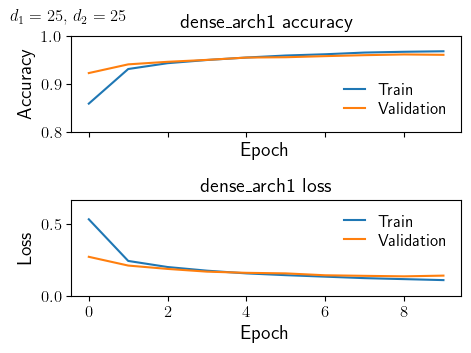

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_141 (Dense)           (None, 25)                19625     
                                                                 
 activation_141 (Activation  (None, 25)                0         
 )                                                               
                                                                 
 dense_142 (Dense)           (None, 50)                1300      
                                                                 
 activation_142 (Activation  (None, 50)                0         
 )                                                               
                                                                 
 dense_143 (Dense)           (None, 10)                510       
                                                                 
 activation_143 (Activation  (None, 10)              

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


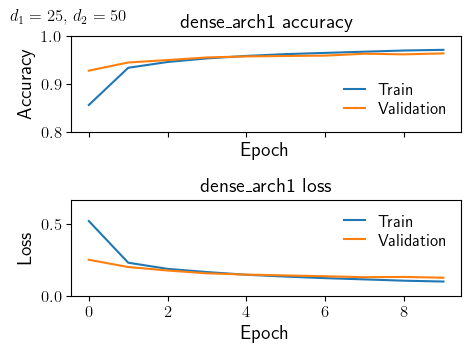

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 25)                19625     
                                                                 
 activation_144 (Activation  (None, 25)                0         
 )                                                               
                                                                 
 dense_145 (Dense)           (None, 100)               2600      
                                                                 
 activation_145 (Activation  (None, 100)               0         
 )                                                               
                                                                 
 dense_146 (Dense)           (None, 10)                1010      
                                                                 
 activation_146 (Activation  (None, 10)              

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


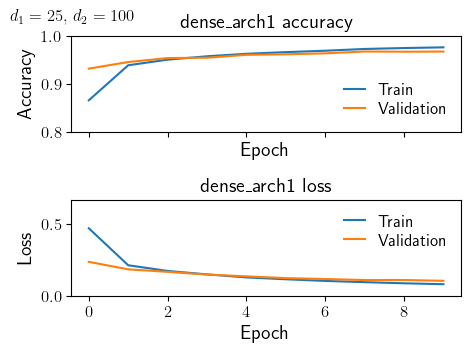

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 25)                19625     
                                                                 
 activation_147 (Activation  (None, 25)                0         
 )                                                               
                                                                 
 dense_148 (Dense)           (None, 200)               5200      
                                                                 
 activation_148 (Activation  (None, 200)               0         
 )                                                               
                                                                 
 dense_149 (Dense)           (None, 10)                2010      
                                                                 
 activation_149 (Activation  (None, 10)              

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


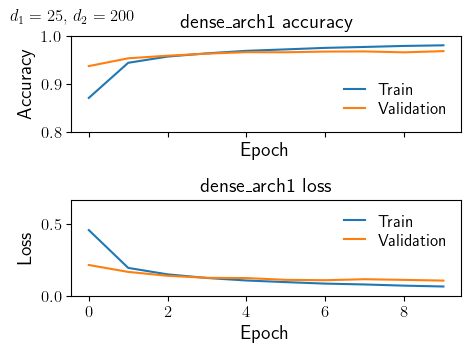

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 50)                39250     
                                                                 
 activation_150 (Activation  (None, 50)                0         
 )                                                               
                                                                 
 dense_151 (Dense)           (None, 25)                1275      
                                                                 
 activation_151 (Activation  (None, 25)                0         
 )                                                               
                                                                 
 dense_152 (Dense)           (None, 10)                260       
                                                                 
 activation_152 (Activation  (None, 10)              

/home/bye/miniconda3/envs/cs156a/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


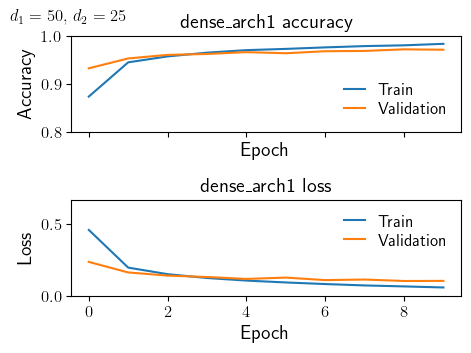

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_153 (Dense)           (None, 50)                39250     
                                                                 
 activation_153 (Activation  (None, 50)                0         
 )                                                               
                                                                 
 dense_154 (Dense)           (None, 50)                2550      
                                                                 
 activation_154 (Activation  (None, 50)                0         
 )                                                               
                                                                 
 dense_155 (Dense)           (None, 10)                510       
                                                                 
 activation_155 (Activation  (None, 10)              

In [64]:
import matplotlib as mpl

mpl.rcParams.update(
    {
        "axes.labelsize": 14,
        "figure.autolayout": True,
        "figure.figsize": (4.875, 3.65625),
        "font.size": 12,
        "legend.columnspacing": 1,
        "legend.edgecolor": "1",
        "legend.framealpha": 0,
        "legend.fontsize": 12,
        "legend.handlelength": 1.25,
        "legend.labelspacing": 0.25,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "text.usetex": True
    }
)

model_name = 'dense_arch1'
regularization=0.00
cwd = os.getcwd()
os.makedirs(os.path.join(cwd, 'exercise', 'img'), exist_ok=True)
os.makedirs(os.path.join(cwd, 'exercise', 'model'), exist_ok=True)
(X_train, y_train), (X_test, y_test) = get_data(False)

cols = {'n1': int, 'n2': int, 'train_accuracy': float, 'train_loss': float,
        'validation_accuracy': float, 'validation_loss': float}
df = pd.DataFrame({c: pd.Series(dtype=t) for c, t in cols.items()})

for n1 in (25, 50, 100, 200, 400):
    for n2 in (25, 50, 100, 200):

        fname = f'{model_name}_{n1=}_{n2=}'
        plot_fname = os.path.join(cwd, 'exercise', 'img', f'{fname}_learn.png')
        model_weights_fname = os.path.join(cwd, 'exercise', 'model', f'{fname}.h5')
        model_json_fname = os.path.join(cwd, 'exercise', 'model', f'{fname}.json')

        model = build_dense_net(regularization, n1, n2)
        model.summary()
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                      metrics=['accuracy'])
        history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1,
                            validation_data=(X_test, y_test))

        model.save(model_weights_fname)
        with open(model_json_fname, 'w') as f:
            f.write(json.dumps(json.loads(model.to_json()), indent=4))

        df.loc[len(df)] = [n1, n2, history.history['accuracy'][-1], 
                           history.history['loss'][-1],
                           history.history['val_accuracy'][-1], 
                           history.history['val_loss'][-1]]

        _, axs = plt.subplots(2, 1, sharex=True)
        axs[0].plot(history.history['accuracy'])
        axs[0].plot(history.history['val_accuracy'])
        axs[0].set_title(f'{model_name} accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].set_ylim((0.8, 1))
        axs[0].legend(['Train', 'Validation'], loc='lower right')

        axs[1].plot(history.history['loss'])
        axs[1].plot(history.history['val_loss'])
        axs[1].set_title(f'{model_name} loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].set_ylim((0, 2 / 3))
        axs[1].legend(['Train', 'Validation'], loc='upper right')

        plt.tight_layout()
        axs[0].text(-2, 1.03, f"$d_1={n1},\,d_2={n2}$")
        plt.savefig(plot_fname)
        plt.show()

df.to_pickle(os.path.join(cwd, 'exercise', f'{model_name}_stats.pkl'))

## Evaluate

Author: Aadyot Bhatnagar

Last modified: March 31, 2022

Description: A script to load and evaluate a saved Keras model's performance on the MNIST dataset of handwritten images. Prints out training and validation loss and accuracy, and also visualizes validation images the model got wrong.

In [ ]:
## Get data in a format compatible with the neural net we want to evaluate
def get_data(model):
    # Import the MNIST dataset using Keras
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Determine input shape that the model given should take
    input_shape = model.get_layer(index=0).input_shape

    # Normalize data to be in [0, 1] and reshape appropriately
    X_train = X_train.reshape(-1, *input_shape[1:]) / 255
    X_test = X_test.reshape(-1, *input_shape[1:]) / 255

    # Convert labels to one-hot vectors (probability distributions w/
    # probability 1 assigned to the correct label)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    return (X_train, y_train), (X_test, y_test)


def main(file_prefix):
    model_name = file_prefix

    # Remove src from cwd if necessary
    cwd = os.getcwd()
    if os.path.basename(cwd) == 'src': 
        cwd = os.path.dirname(cwd)

    # Create img directory to save images if needed
    os.makedirs(os.path.join(cwd, 'img'), exist_ok=True)

    # Create model directory to save models if needed
    os.makedirs(os.path.join(cwd, 'model'), exist_ok=True)
    model_weights_fname = os.path.join(cwd, 'model', f'{model_name}.h5')
    model_json_fname = os.path.join(cwd, 'model', f'{model_name}.json')

    # Load model and its weights
    with open(model_json_fname, 'r') as f: 
        model_json = f.read()
    model = model_from_json(model_json)
    model.load_weights(model_weights_fname)

    # Get MNIST data shaped appropriately for the model
    (X_train, y_train), (X_test, y_test) = get_data(model)

    # Compile model and evaluate its performance on training and test data
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])

    score = model.evaluate(X_train, y_train, verbose=0)
    print()
    print('Training loss:', score[0])
    print('Training accuracy:', score[1])

    score = model.evaluate(X_test, y_test, verbose=0)
    print()
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])

    # Determine validation examples that the model got wrong
    y_pred = np.array([np.argmax(y) for y in model.predict(X_test)])
    y_true = np.array([np.argmax(y) for y in y_test])
    mistakes = (y_pred != y_true)
    X_wrong = X_test[mistakes].reshape(-1, 28, 28) # To visualize properly
    y_wrong = y_pred[mistakes]
    y_right = y_true[mistakes]

    # Visualize some of the validation examples the model got wrong
    nrow, ncol = 3, 5
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol)
    for i in range(nrow):
        for j in range(ncol):
            idx = i * ncol + j
            ax = axs[i][j]
            ax.imshow(X_wrong[idx], cmap='gray')
            ax.set_title(f'Pred: {y_wrong[idx]}\nTrue: {y_right[idx]}')
            ax.axis('off')
    fig.tight_layout(pad=2.5)
    plt.suptitle(f'Validation Images {model_name} Got Wrong')
    plt.savefig(os.path.join(cwd, 'img', f'{model_name}_mistakes.png'))
    plt.show()

In [ ]:
main(FILE_PREFIX)